### Implementation
* Move to Python3
* Git hub update
* Load Pierre protein list
* Check for exisiting path between any node and a seed node after edge trimming
* Remove network not connected with seed node 

### Study
$\Delta$ SimPct treshold

 * How many networks
 * Tabulate individual protein degree across the generated networks

| Protein| 80% | 60% | ... | 10% |
| ------ | --- | --- | --- | --- |
| XXX    | 22  | 10  | ... | NA  |



GO analysis:
* Global tablechart of GO terms occurences across the network
* For given Protein and its 1st neighbors, display the GO annotations distribution of the proteins and their templates

TODO 

  1. Récuperer interaction experiemntals suplémentaires
  2. Alignement de séquences sur protéines du divisome
  3. Définition de blocs
  4. Métrique homologie basée sur la similarité dans ces blocs.



In [1]:
import sys
import os
import subprocess
sys.path.append('/Users/guillaumelaunay/work/projects/pneumocoque/omegaLoMo/lib')
sys.path.append("/Users/guillaumelaunay/work/DVL/python3/pyproteinsExt/src")
sys.path.append("/Users/guillaumelaunay/work/DVL/python3/pyproteins/src")

%load_ext autoreload

In [2]:
import pandas
import json

def loadSeedList(lType='all'):
    rootDir='/Users/guillaumelaunay/work/projects/pneumocoque/lists'
    fileMap = {
        'phino' : 'DivAlreadyKnow_litt_phino.txt',
        'massida' : 'DivAlreadyKnow_litt_massida.txt',
        'barletMerge': 'divKnownR6.txt',
        'garcia' : 'pierre_uniprot_DL.tsv',
        'all' : 'current_merge.txt'
    }
    if lType not in fileMap:
        raise IndexError("no set named " + lType)
        
    pFrame = pandas.read_csv( rootDir + '/' + fileMap[lType], sep='\t', lineterminator='\n')
    return [ uniprotID for uniprotID in pFrame.loc[:]["Entry"] ]



* MITAB_file and filterIds can be filled when reading serialized data, or read from scratch, using input files.
* MITAB_file contains IntAct informations, restricted to physical interactions. 
It is a subset of the informations
from /mobi/group/divisome/physical_intact.mitab.txt, after serialization by an external python script.
* filterIds contains information about S pneumoniae
* intactR6filtered_topology is a dictionary, with pairs of UniProt Ids of proteins from IntAct interactions, that match with R6 sequences,
non redundant.

## Combining experimental evidences and homology relationship

### $I^{st}$ input *psicquic.MitabTopology* object

##### Previously pickled psicquic.MitabTopology object (see R6 topology notebook)

It can be viewed as a tree representation of an adjacency matrix
with non-zero cell elements storing list of mitab experimental evidences.

The actual data structure is a 2 level dictionnary of uniprotID keys referencing list of mitab informations


```json
{
    psicquicInteractorID : {
        psicquicInteractorID : [ psqDataObject , ...]
    }
    
}

```

API description

In [3]:
import pickle
#mitabTopologyPickle="/Users/guillaumelaunay/tmp/buildNetwork2/uniprot_safe.H50.mitabToplogy.pickle"
mitabTopologyPickle="/Users/guillaumelaunay/tmp/buildNetwork2/uniprot_safe.mitabToplogy.pickle"
mitabTopologyObject = None
with open(mitabTopologyPickle, 'rb') as fP:
    mitabTopologyObject = pickle.load(fP)
print("Number of interaction unpickled", len(mitabTopologyObject) )

Number of interaction unpickled 54993


In [4]:
mitabTopologyObject["P38801"]["P24783"]

[uniprotkb:P24783	uniprotkb:P38801	intact:EBI-5602|uniprotkb:Q05456|uniprotkb:D6W169	intact:EBI-1909|uniprotkb:D3DL32	psi-mi:dbp2_yeast(display_long)|uniprotkb:DBP2(gene name)|psi-mi:DBP2(display_short)|uniprotkb:YNL112W(locus name)|uniprotkb:N1945(orf name)|uniprotkb:DEAD box protein 2(gene name synonym)|uniprotkb:p68-like protein(gene name synonym)	psi-mi:lrp1_yeast(display_long)|uniprotkb:LRP1(gene name)|psi-mi:LRP1(display_short)|uniprotkb:Like an rRNA processing protein 1(gene name synonym)|uniprotkb:rRNA processing protein 47(gene name synonym)|uniprotkb:RRP47(gene name synonym)|uniprotkb:YC1D(gene name synonym)|uniprotkb:Yeast C1D domain-containing protein(gene name synonym)|uniprotkb:YHR081W(locus name)	psi-mi:"MI:0111"(dihydrofolate reductase reconstruction)	Tarassov et al. (2008)	pubmed:18467557|mint:MINT-6673767|imex:IM-14275	taxid:559292(yeast)|taxid:559292(Saccharomyces cerevisiae)	taxid:559292(yeast)|taxid:559292(Saccharomyces cerevisiae)	psi-mi:"MI:0915"(physical associa

### $II^{nd}$ input *homology tree-like* document

Two level tree storing homology relationship between psicquic entries (**PSQ**) (primary keys) and
target proteome (**TP**) entries (secondary keys)
Leaves are array which contains one tuple per HSP (currently only one HSP)
HSP informations are

 **TP** sequence Length**,** **TP**_hsp start position**,** **TP**_hsp stop position**,** **PSQ**_sequence Length**,** **PSQ**_hsp start position**,** **PSQ**_hsp stop position**,** HSP positive match number**,** HSP identical match number**,** HSP eValue

```json
{
"P97760": {"P66709": [["311", "5", "235", "275", "5", "272", "95", "45", "4.79675e-27"]]},
"P98084": {"Q59947": [["1963", "262", "811", "750", "24", "572", "176", "95", "2.1715e-07"]], "Q8DQN5": [["1876", "191", "395", "750", "52", "281", "75", "47", "1.90067e-06"]]},
}
```


In [4]:
homologyFile="/Users/guillaumelaunay/tmp/buildNetwork2/uniprot_R6_homology.json"

## Building network Topology  TO REVISED


##### **buildEdges ** 
Performs the homolog expansion

**args**:None

##### **resetEdges** 
Any network can be reverted to the state obtained at **buildEdge** completion

**args**:None
##### **trimEdges**
Discard homology relationship violating treshold-based constraints.
An edge without remaining homology relationship is removed

**args**: optional,named
 * idPct
 * simPct
 * cvPct
 
##### **nodes**
A dictionary attribute with network node and their supporting PSQ protein. 
```
{
    node_UniprotID : { PSQ_uniprotID, ... }
}
```



In [5]:
%autoreload 2
import networkx as nx
import omega

In [6]:
om = omega.omegaTopology(mitabTopologyObject, homologyFile)
om.buildEdges()

seedList=loadSeedList()


def trimPruneTest(omegaObj, idPct, _seedList):
    _nList = []
    print("Current number of edges " + str(om.edgeNumber) )
    om.trimEdges(idPct=idPct)
    _nList.append( list(om.nodes.keys()) )
    x = (om.edgeNumber, om.nodeNumber)
    print(str(om.edgeNumber), str(om.nodeNumber),' edges/nodes after triming' )
    G=om.prune(*_seedList)
    _nList.append( list(om.nodes.keys()) )
    print(str(om.edgeNumber), str(om.nodeNumber),' edges/nodes after pruning' )
    y = (om.edgeNumber, om.nodeNumber)
    return G, x, y, _nList


84127  interactions unpacked from  54993


In [7]:
G, x, y, _nList=trimPruneTest(om, 50.00, seedList)

Current number of edges 84127
83802  interactions trimmed from total  84127
325 169  edges/nodes after triming
260 101  edges/nodes after pruning


In [13]:
om.jupyterNodeView()

Q8CWN9,36
P59661,30
Q8DRB3,19
Q8DPS0,16
Q8CWT4,13
Q8CWT2,13
P63545,12
Q8DNI9,10
P65947,9
Q8DQL6,9
P65888,8


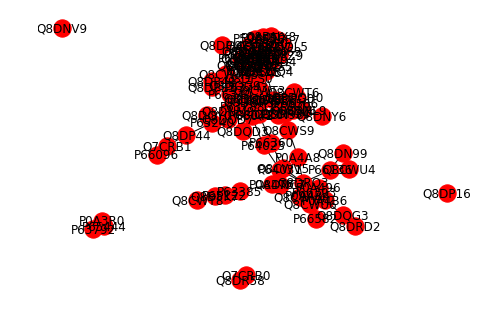

In [9]:
nx.draw(G, with_labels=True)

## Node template assignment robustness to similarity treshold

Ploting following datastructure which represents features of a serie of networks as a function of an edge triming parameter (eg: identity)

```python
([60, 65, 70, 75, 80, 85, 90, 95, 100],  # [0] is %idPCt
 {'P0A2W7': [7, 7, 7, 7, 7, 7, 7, 6, 0], # [1] is a dict of node degree along id threshold
  'P0A336': [6, 2, 2, 2, 2, 2, 2, 2, 0], 
  'P0A496': [1, 0, 0, 0, 0, 0, 0, 0, 0],
  # ...,
  },
 [                 # [2] is a list (one element per id threshold)trimedOnly, prunedTo 2-uple of (edges, node)
 ((4217, 756), (4118, 708)),   
 ((2104, 534), (2056, 492)),
 ((1076, 400), (1028, 352))
 # ...,
 ],
 [      # [3] ia a list (one element per id thresehold) of list pairs (trimmedOnly, pruned Too) of node label
 [['Q8DPJ9',    
   'Q8DP89',
   'Q8DQ95',
   # ...,
   ],
   [
   'Q8DMW9',
   'Q8DMW1',
   'Q8DMY0'
   # ...,
   ]]
   # ..., Next id thresehold
 ]
)
 ``` 

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse
from matplotlib.colors import Normalize

In [10]:
def singleLineChart(topologyObject, _seedList, idPctMin=10, step=5):
    x = []
    d = {}
    tot= []
    nodeList = []
    for idPct in range(idPctMin, 100 + step, step):
        x.append(idPct)
        G, trimNums, prunNums, nList = trimPruneTest(topologyObject, idPct, _seedList)
        if not d:
            for n in nx.degree(G):
                d[n[0]] = []
        for k in d:
            d[k].append(0)
            
        for n in nx.degree(G):
             d[n[0]][-1] = n[1]
        tot.append((trimNums, prunNums))
        nodeList.append(nList)
    return (x, d, tot, nodeList)

In [11]:
data = singleLineChart(om, seedList, idPctMin=30, step=5)

Current number of edges 260
79910  interactions trimmed from total  84127
4217 756  edges/nodes after triming
4118 708  edges/nodes after pruning
Current number of edges 4118
82023  interactions trimmed from total  84127
2104 534  edges/nodes after triming
2056 492  edges/nodes after pruning
Current number of edges 2056
83051  interactions trimmed from total  84127
1076 400  edges/nodes after triming
1028 352  edges/nodes after pruning
Current number of edges 1028
83488  interactions trimmed from total  84127
639 290  edges/nodes after triming
598 241  edges/nodes after pruning
Current number of edges 598
83802  interactions trimmed from total  84127
325 169  edges/nodes after triming
260 101  edges/nodes after pruning
Current number of edges 260
83884  interactions trimmed from total  84127
243 123  edges/nodes after triming
189 67  edges/nodes after pruning
Current number of edges 189
83928  interactions trimmed from total  84127
199 97  edges/nodes after triming
162 54  edges/nodes 

In [31]:
data[3]

[[['Q8DPJ9',
   'Q8DP89',
   'Q8DQ95',
   'Q8DMW9',
   'Q8DMW1',
   'Q8DMY0',
   'Q8DQY3',
   'P0A454',
   'P0A2U9',
   'Q8DQL1',
   'P0A4M8',
   'Q8DNM1',
   'Q8DP03',
   'Q8DPK4',
   'Q8DNJ8',
   'Q8DP77',
   'Q8DRC8',
   'Q8DRF9',
   'Q8DMX9',
   'Q8DQH4',
   'Q8DMY8',
   'P64031',
   'Q8DQA2',
   'Q8DR19',
   'Q8DQI7',
   'Q8DNW6',
   'Q8DQD4',
   'Q8DQF8',
   'Q8DPD1',
   'Q8DPC2',
   'P0A336',
   'P0A2Y7',
   'Q8DPF5',
   'Q8DR45',
   'P64063',
   'P0A3C4',
   'Q8DPZ8',
   'Q8DQN2',
   'Q8DRQ3',
   'Q8DPQ4',
   'Q8DMW2',
   'Q8DQV2',
   'Q8DN05',
   'Q8DP39',
   'Q8DQI3',
   'Q8CWS5',
   'Q8DQ79',
   'Q8DP13',
   'Q8DP29',
   'P0A3C6',
   'Q59947',
   'Q8DQN5',
   'P0A4D8',
   'Q8DMX2',
   'Q8DQH1',
   'Q8CWT3',
   'Q8DPM1',
   'P59652',
   'Q8DPL5',
   'Q8DQD3',
   'Q8DPJ8',
   'Q8CWU4',
   'P61183',
   'Q8CWR0',
   'Q8DQT0',
   'Q8CWT2',
   'Q8DNX8',
   'Q8DQ60',
   'Q8DPZ3',
   'Q8DQT2',
   'Q8CWN5',
   'Q8CWR9',
   'Q8DR96',
   'Q8DNZ7',
   'Q8DQG5',
   'Q8CYJ1',
   'Q8DPH1',

In [24]:

seedNumber = [ len ( set(seedList) & set (u[1]) ) for u in data[3] ]
_seedNumber = sorted(seedNumber, reverse=True)
#data[3][2][1]
_seedNumber

[34, 25, 14, 11, 7, 6, 5, 4, 4, 4, 4, 4, 4, 4, 1]

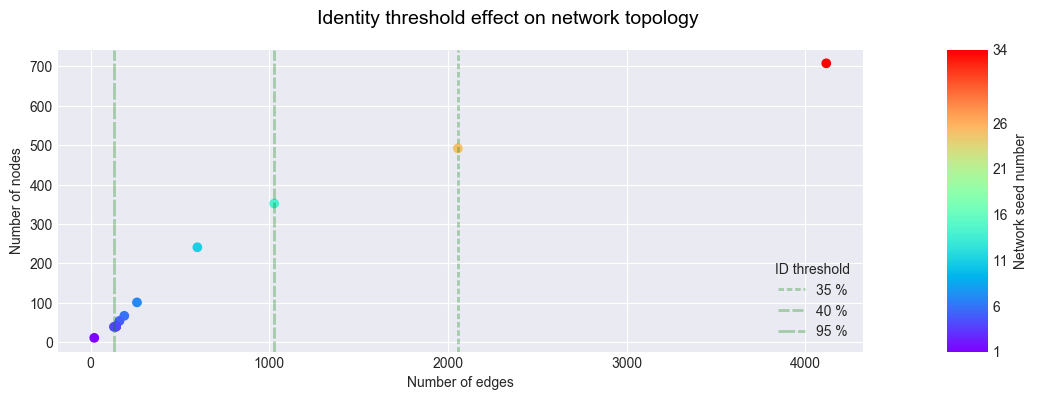

In [30]:
seedNumber = [ len ( set(seedList) & set (u[1]) ) for u in data[3] ]
_seedNumber = sorted(seedNumber)
pruneToo = [ u[1] for u in data[2] ]


cmap = plt.cm.rainbow
norm = Normalize(vmin=_seedNumber[0], vmax=_seedNumber[-1])


fig, (ax, cax) = plt.subplots(1,2,figsize=(12, 4), dpi=100,
                  gridspec_kw={"width_ratios":[1, 0.05]}
                             )
plt.style.use('seaborn-darkgrid')

fig.suptitle("Identity threshold effect on network topology", fontsize=14, fontweight=4, color='black')
ax.set_ylabel("Number of nodes")
ax.set_xlabel("Number of edges")

markerColorMap = [ cmap(norm(i)) for e, i in enumerate(seedNumber) ]
#ax.scatter([ x[0] for x in trimOnly ], [ x[1] for x in trimOnly ], c=markerColorMap)#, linewidth=1.8, alpha=0.3)
ax.scatter([ x[0] for x in pruneToo ], [ x[1] for x in pruneToo ],  c=markerColorMap)
## Draw threshold iformation

threshX = [ x[0] for x in pruneToo ]
threshold = data[0]
threshold[1]
threshold[-2]
threshold[int(len(data)/2)]

ax.axvline(x=threshX[1],c='green',label=str(threshold[1]) + ' %', dashes=(2,1), linewidth=2, alpha=0.3)
ax.axvline(x=threshX[int(len(data)/2)],c='green',label=str(threshold[int(len(data)/2)]) + ' %', dashes=(4,1), linewidth=2, alpha=0.3)
ax.axvline(x=threshX[-2],c='green',label=str(threshold[-2]) + ' %', dashes=(6,1), linewidth=2, alpha=0.3)

ax.legend(title='ID threshold', loc='lower right')

v = np.arange(_seedNumber[0], _seedNumber[-1], 5)
v[-1] = _seedNumber[-1]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, cax=cax, ticks=v)
u=cax.set_ylabel("Network seed number")



In [28]:

seedData

{'P59652': [47, 20, 5, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'P59658': [6, 5, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'P63641': [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'P63792': [26, 9, 7, 5, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'P65467': [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'Q7ZAK7': [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0],
 'Q8CWP7': [4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'Q8CWP9': [7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'Q8CWQ5': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'Q8DMW1': [8, 7, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'Q8DN83': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'Q8DNC4': [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'Q8DNI9': [12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 5],
 'Q8DNR6': [15, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'Q8DNS0': [8, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'Q8DNV8': [10, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'Q8DNV9': [11, 8, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [78]:
# Behaviour of seed proteins
import seaborn as sns

def popKeyAlongAverageDegree(_nodeData):
    return sorted( _nodeData.keys(), key = lambda k : sum(_nodeData[k]) / len(_nodeData[k]), reverse=True )

def drawSingleChart(data, nodeList, nr=6, nc=6, title = ""):
    nodeData = { k  : data[1][k] for k in data[1] if k in nodeList }

    palette = sns.color_palette("hls", len(nodeData) + 1)

# Initialize the figure
    plt.style.use('seaborn-darkgrid')
 
# create a color palette
#palette = plt.get_cmap('tab20c')

    all = set()
    for k in nodeData:
        all.update(nodeData[k])
    
    _min = min(all)
    _max = max(all)

    plt.figure(figsize=(20,20))


    

# multiple line plot
    num=0
    for node in popKeyAlongAverageDegree(nodeData):
        num+=1
    
    # Find the right spot on the plot
        plt.subplot(nr, nc, num)
    
#    color = palette(num%20)
        color = palette[num]
    # plot every groups, but discreet
        for n in nodeData:
            plt.plot(data[0], nodeData[n], marker='', color='grey', linewidth=0.6, alpha=0.3)
 
    # Plot the lineplot
        plt.plot(data[0], nodeData[node], marker='', color=color, linewidth=2.4, alpha=0.9)#, label=str(node))
 
    # Same limits for everybody!
        plt.xlim(data[0][0],data[0][-1])
        plt.ylim(_min,_max)
 
    # Not ticks everywhere
    #if num in range(7) :
    #    plt.tick_params(labelbottom='off')
    #if num not in [1,4,7] :
    #    plt.tick_params(labelleft='off')
 
    # Add title
        plt.title(str(uColl.get(node).geneName) + '    [' + str(max(nodeData[node])) + ',' + str(min(nodeData[node])) + ']', 
                  loc='left', fontsize=20, fontweight="bold", color=color )
 
# general title
    plt.suptitle(title, fontsize=30, fontweight=0, color='black', style='italic', y=0.925)
 
# Axis title
    plt.gcf().text(0.5, 0.1, 'Identity Pct', ha='center', va='center', fontsize=30)
    u=plt.gcf().text(0.1, 0.5, 'Degree', ha='center', va='center', rotation='vertical', fontsize=30)


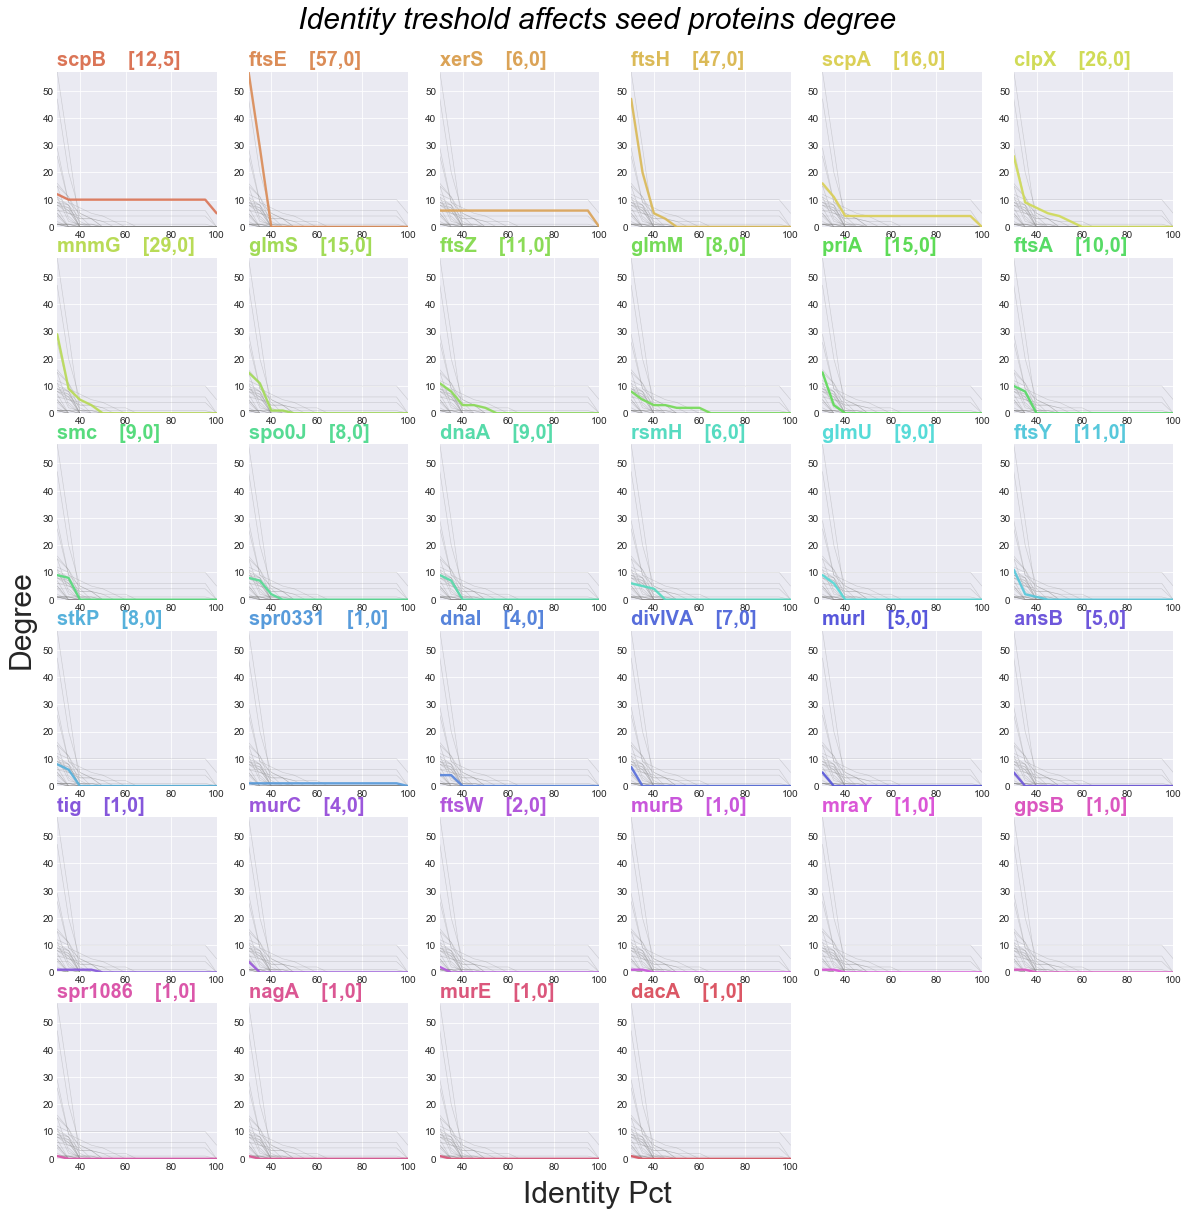

In [79]:
drawSingleChart(data, seedList, title="Identity treshold affects seed proteins degree")

In [72]:
uColl.get("P98160").geneName

'HSPG2'

In [70]:
# Get the seed 1st neighbours at 50% id
# Compute average degree over set of trimmed networks
G, x, y, _nList=trimPruneTest(om, 50.00, seedList)
nodePool = [ n for n in _nList[1] if predicate(n, G, seedList) ]
print ("The number of 1st neighbors of seed nodes at 5O% step is",len(nodePool))

Current number of edges 260
83802  interactions trimmed from total  84127
325 169  edges/nodes after triming
260 101  edges/nodes after pruning
Q8DNI9 is a seed
Q7ZAK7 is a seed
Q9EUQ7 is a seed
P63792 is a seed
Q8DNV9 is a seed
Q8DP16 is a seed
Q8DR58 is a seed
The number of 1st neighbors of seed nodes at 5O% step is 16


In [39]:
def predicate(n, _G, seedList):
    seedNodes = [ n for n in G.nodes if n in seedList ]
    
    if n in seedNodes:
        print(n, "is a seed")
        return False

    
    seedBound = False
    for s in seedNodes: 
        try:
            lPath = nx.shortest_path(G,source=n,target=s)
        except:
            lPath = []
    
        if len(lPath) == 2:
            seedBound = True
            break
    
    return seedBound


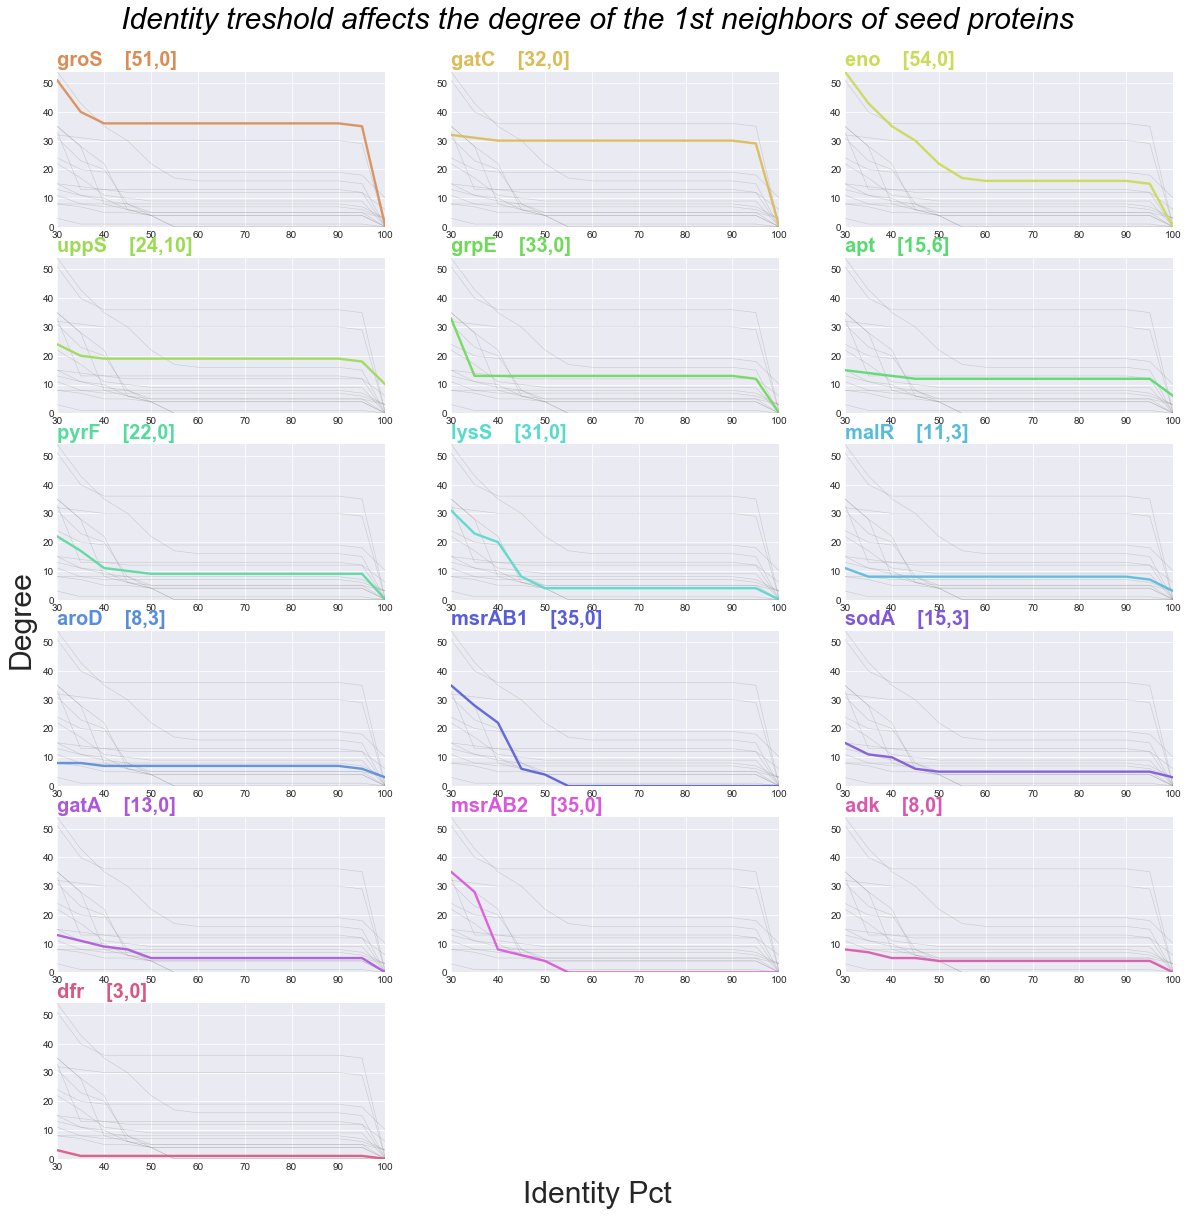

In [82]:
drawSingleChart(data, nodePool, nr=6, nc = 3, title="Identity treshold affects the degree of the 1st neighbors of seed proteins")

In [ ]:
# NOT so interesting
plt.style.use('seaborn-darkgrid')
my_dpi=96
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)


plt.title("Evolution of nodes degree with identity threshold", loc='center', fontsize=14, fontweight=4, color='black')
plt.xlabel("Identity Pct Threshold")
plt.ylabel("Degree")



for name in data[1]:
    c = 'grey' if data[1][name][-1] == 0 else 'orange'
    w =  0.6 if data[1][name][-1] == 0 else 2.4
    plt.plot(data[0],data[1][name], marker='', color=c, linewidth=w, alpha=0.3)
#plt.plot([0,2,4],[0,2,4], marker='', color='blue', linewidth=0.6, alpha=0.3)


## Enriching network

### Building supporting uniprot collection

In [51]:
import pyproteinsExt.uniprot as uniprot
from pyproteinsExt.uniprot import EntryEncoder


uColl = uniprot.getUniprotCollection()
uColl.setCache(location='/Users/guillaumelaunay/work/data/uniprot')
uniprot.proxySetting(https="http://ftprox.ibcp.fr:3128", http="http://ftprox.ibcp.fr:3128")

Acknowledged 0 entries (/Users/guillaumelaunay)
Changing cache location to /Users/guillaumelaunay/work/data/uniprot
Reindexing /Users/guillaumelaunay/work/data/uniprot
Acknowledged 11306 entries (/Users/guillaumelaunay/work/data/uniprot)
!!Proxy set to {'https': 'http://ftprox.ibcp.fr:3128', 'http': 'http://ftprox.ibcp.fr:3128'}


In [73]:
om.nodes

{'P0A2W7': {'P0A2W6', 'P96618'},
 'P0A2Y7': {'P31104'},
 'P0A336': {'O69289',
  'P0A335',
  'P0A6F5',
  'P10809',
  'P19882',
  'P42383',
  'P78012',
  'Q05972',
  'Q9VPS5',
  'Q9ZN50'},
 'P0A3B8': {'P80700'},
 'P0A3R0': {'O25011', 'P0A746'},
 'P0A3R2': {'P49850'},
 'P0A3Y4': {'P00950', 'P07738', 'P15259', 'P16290', 'P18669'},
 'P0A452': {'P16971', 'Q0P7V6'},
 'P0A472': {'O83268', 'P02394', 'P0A7K2', 'P36210', 'Q9PI32'},
 'P0A476': {'P41204', 'P56041', 'Q9PLX8'},
 'P0A484': {'Q50310'},
 'P0A496': {'O83239', 'P0A7Q6', 'P52864'},
 'P0A4A8': {'P17293', 'P53732', 'P75546'},
 'P0A4B4': {'Q03246', 'Q50309', 'Q9PLY0'},
 'P0A4B6': {'P0A7U3', 'P21476', 'P75576'},
 'P0A4C4': {'P21465', 'P41205', 'P73314'},
 'P0A4D8': {'O25029', 'P0A8J8', 'P96614'},
 'P0A4J0': {'P00579', 'P06224', 'P55993', 'P74565', 'Q59996'},
 'P0A4J7': {'P04179', 'P0A4J6', 'P0AGD3', 'P54375', 'Q0PBW9'},
 'P0A4M0': {'P0AES6', 'P22447', 'P55992', 'P77966', 'P78016'},
 'P0A4M6': {'O25151', 'P0A862', 'P80864', 'Q9PPE0', 'Q9ZKE7'},

In [143]:
# Create a collection of all uniprot entities in a network
class NetworkUniprotCollection:
    def __init__(self, omegaTopologyObject, uniprotMainCollection):
        self.networkUP = {}
        self.upDic = omegaTopologyObject.nodes
        for n in self.upDic:
            l = [n] + list(self.upDic[n])
            for x in l:
                if x not in self.networkUP:
                    self.networkUP[x] = uniprotMainCollection.get(x)
        # write to FS if fetched were performed
        uniprotMainCollection.serialize()
        print("loaded" + str(len(self)) + ' uniprot entries')
    
    def __len__(self):
        return len(self.networkUP)
    
    def GOview(self):
        goChart = uniprot.keyWordChart([ self.networkUP[x] for x in self.networkUP ])

        return htmlTable([ ( x[0], len(x[1]) ) for x in goChart ], ['GO term', 'Occurence'])

class htmlTable:
    def __init__(self, data, headers):
        self.data = data
        self.headers = headers
    def _repr_html_(self):
        htmlString = '<table><thead><th>' + '</th><th>'.join(self.headers) + '</th></thead><tbody>'
        for datum in self.data:
            htmlString += '<tr><td>' + '</td><td>'.join([ str(d) for d in datum ]) + '</td></tr>'

        htmlString += '</tbody></table>'

        return htmlString



In [144]:
netUniColl = NetworkUniprotCollection(om, uColl)
uniprotJsonString = json.dumps({"registry" : netUniColl.networkUP },  cls=EntryEncoder)
#uniprotJsonString

serializing uniprot collection
0 entries updated, total pool is 11306
serializing pfam collection
0 entries updated, total pool is 11221
loaded1192 uniprot entries


In [10]:
tag="uniprot_id40NTW"

jsonBean = om.dump()

with open("/Users/guillaumelaunay/tmp/buildNetwork2/" + tag + ".json", "w") as fp:
    fp.write(str(jsonBean).replace("\'", "\"")[:-1] + ", " + uniprotJsonString[1:] )

### Building supporting mitab collection

* Filtering _mitabObject_ for pair of template founds in the network
* write a mitab formated file of the filtered interactions

In [19]:
tColl = om.templateZipPair()
mitabTopologyObject.autoAppendable=True
mitabAsStr = ''
for t1, t2, d in tColl:
     mitabAsStr +=  '\n'.join( [ str(psq) for psq in mitabTopologyObject[t1][t2] ] )

with open("/Users/guillaumelaunay/tmp/buildNetwork2/" + tag + ".mitab", "w") as fp:
    fp.write(mitabAsStr)

## Miscellanous network properties


#### Go term distribution

In [146]:
netUniColl.GOview()

GO:0005737:C:cytoplasm{ECO:0000501},414
GO:0005524:F:ATP binding{ECO:0000501},404
GO:0005829:C:cytosol{ECO:0000318},316
GO:0006412:P:translation{ECO:0000501},138
GO:0003735:F:structural constituent of ribosome{ECO:0000318},133
GO:0046872:F:metal ion binding{ECO:0000501},122
GO:0000287:F:magnesium ion binding{ECO:0000501},106
GO:0003677:F:DNA binding{ECO:0000501},98
GO:0005886:C:plasma membrane{ECO:0000314},89
GO:0019843:F:rRNA binding{ECO:0000501},86
GO:0042802:F:identical protein binding{ECO:0000353},85


### Go Term analysis TO REWORK

 * Enriching a network in uniprot object
 * Returns a GO terms chart

In [109]:
(goScoreQ, goScoreT) = GOneighbouring(G, "P0A2W7")

6  Templates and  6  Queries uniprot entities to create
got to fetch Q8CWN9
got to fetch Q8CWN9
got to fetch P59661
got to fetch P59661
got to fetch Q8CWT4
got to fetch Q8CWT4
got to fetch Q8CWT2
got to fetch Q8CWT2
got to fetch Q8DRB3
got to fetch Q8DRB3
got to fetch Q97NV3
got to fetch Q97NV3
got to fetch P0A2W6
got to fetch P0A2W6
got to fetch Q97SE5
got to fetch Q97SE5
got to fetch Q97S73
got to fetch Q97S73
got to fetch P95830
got to fetch P95830
got to fetch Q97SR4
got to fetch Q97SR4


In [ ]:
def GoPick(G, nodeName):    
    nx.ego_graph(G, nodeName, radius)
    # list Each node template
    # Try to fetch GO term
    

### Node centrality with respect to seed nodes

In [14]:
G, trimNums, prunNums, nList = trimPruneTest(om, 60.0, seedList)

Current number of edges 143
83928  interactions trimmed from total  84127
199 97  edges/nodes after triming
162 54  edges/nodes after pruning


In [16]:
seedCentrality = {}
seedNodes = [ n for n in G.nodes if n in seedList ]
print(seedNodes)

for n in G.nodes:
    if n in seedList:
        continue
    seedCentrality[n] = []
    for s in seedNodes:
        lPath=[]
        try:
            lPath = nx.shortest_path(G,source=n,target=s)
        except:
            lPath = []
        seedCentrality[n].append(lPath)
#    seedCentrality[n] = [ nx.shortest_path(G,source=n,target=s) for s in seedNodes ]

seedCentrality

['Q8DNI9', 'Q7ZAK7', 'Q9EUQ7', 'Q8DP16', 'Q8DR58']


{'P0A2W7': [['P0A2W7', 'Q8DRB3', 'Q8DNI9'],
  ['P0A2W7', 'Q8CWN9', 'Q7ZAK7'],
  ['P0A2W7', 'Q8CWN9', 'Q9EUQ7'],
  [],
  []],
 'P0A336': [['P0A336', 'Q8CWN9', 'Q8DNI9'],
  ['P0A336', 'Q8CWN9', 'Q7ZAK7'],
  ['P0A336', 'Q8CWN9', 'Q9EUQ7'],
  [],
  []],
 'P0A496': [['P0A496',
   'Q8DRQ3',
   'P0A4A8',
   'Q8CWS9',
   'P0A336',
   'Q8CWN9',
   'Q8DNI9'],
  ['P0A496', 'Q8DRQ3', 'P0A4A8', 'Q8CWS9', 'P0A336', 'P63545', 'Q7ZAK7'],
  ['P0A496', 'Q8DRQ3', 'P0A4A8', 'Q8CWS9', 'P0A336', 'Q8CWN9', 'Q9EUQ7'],
  [],
  []],
 'P0A4A8': [['P0A4A8', 'Q8CWS9', 'P0A336', 'Q8CWN9', 'Q8DNI9'],
  ['P0A4A8', 'Q8CWS9', 'P0A336', 'P63545', 'Q7ZAK7'],
  ['P0A4A8', 'Q8CWS9', 'P0A336', 'Q8CWN9', 'Q9EUQ7'],
  [],
  []],
 'P0A4B6': [['P0A4B6',
   'Q8DRQ3',
   'P0A4A8',
   'Q8CWS9',
   'P0A336',
   'Q8CWN9',
   'Q8DNI9'],
  ['P0A4B6', 'Q8DRQ3', 'P0A4A8', 'Q8CWS9', 'P0A336', 'P63545', 'Q7ZAK7'],
  ['P0A4B6', 'Q8DRQ3', 'P0A4A8', 'Q8CWS9', 'P0A336', 'Q8CWN9', 'Q9EUQ7'],
  [],
  []],
 'P0A4J7': [['P0A4J7', 'Q8DNI9'],
  ['P

In [40]:
#data = [ [ len(x) - 1 if len(x) > 0 else None for x in v ] for k,v in seedCentrality.items() ]
#data = [ [ len(x) - 1 for x in v ] for k,v in seedCentrality.items() ]
data = []
label=[]
for k,v in seedCentrality.items():
    data.append([ len(x) - 1 for x in v ] )
    label.append( uColl.get(k).name )

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array 
  alpha: float (0.0 transparent through 1.0 opaque) 
  animated: bool 
  backgroundcolor: any matplotlib color 
  bbox: FancyBboxPatch prop dict 
  clip_box: a :class:`matplotlib.transforms.Bbox` instance 
  clip_on: [True | False] 
  clip_path: [ (:class:`~matplotlib.path.Path`, :class:`~matplotlib.transforms.Transform`) | :class:`~matplotlib.patches.Patch` | None ] 
  color: any matplotlib color 
  contains: a callable function 
  family or fontfamily or fontname or name: [FONTNAME | 'serif' | 'sans-serif' | 'cursive' | 'fantasy' | 'monospace' ] 
  figure: a `~.Figure` instance 
  fontproperties or font_properties: a :class:`matplotlib.font_manager.FontProperties` instance 
  gid: an id string 
  horizontalalignment or ha: [ 'center' | 'right' | 'left' ] 
  label: object 
  linespacing: float (multiple of font size) 
  multialignment or ma: ['left' | 'right' | 'center'

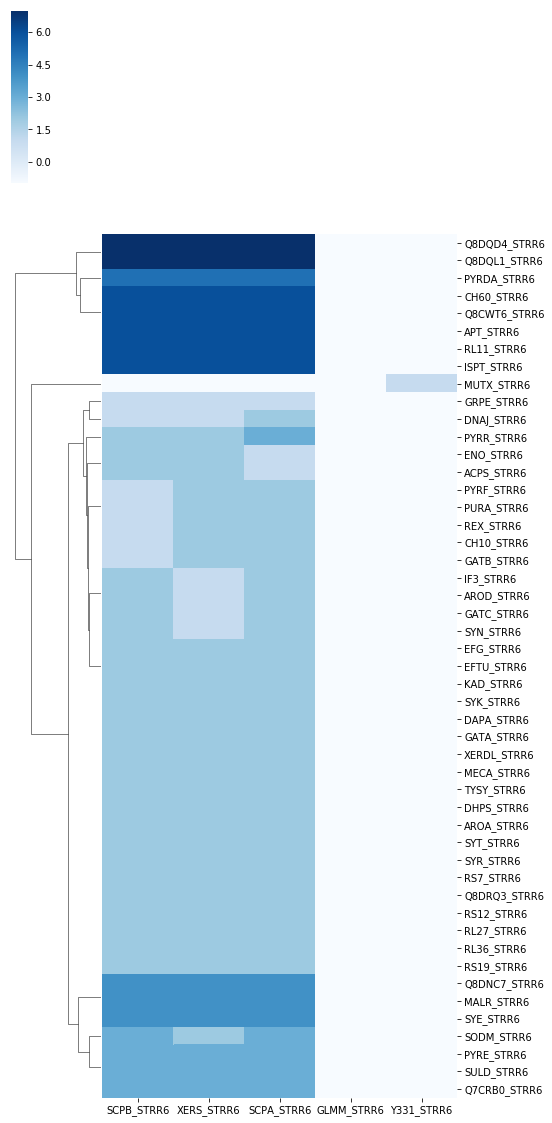

In [44]:
cg=sns.clustermap(data, cmap="Blues", col_cluster=False,  yticklabels=1)
plt.setp(cg.ax_heatmap.set_xticklabels([ uColl.get(k).name for k in seedNodes ] ))
plt.setp(cg.ax_heatmap.set_yticklabels(label))
#plt.figsize(20,20)

plt.gcf().set_size_inches(8, 20)
